In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.proportion import proportion_confint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
#df = pd.read_csv('https://edu.tinkoff.ru/media/edu-files-ext-100/33d8648c-b016-49ed-8888-62dc0f35112c.csv', sep=',')
df = pd.read_csv('/home/marina/Documents/data_analysis/installments_and_credits.csv')
df.shape

(10000, 7)

In [8]:
df.sample(5)

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
6702,6703,169980.0,0,90000,48,0,0
9413,9414,31774.0,0,85000,23,1,1
2298,2299,36462.0,1,60000,30,1,1
6711,6712,18799.0,1,60000,26,0,0
8149,8150,78741.0,1,183500,42,1,0


№1

Построить предсказательные интервалы для ежемесячного дохода и запрошенной суммы (в предположении логнормальности)

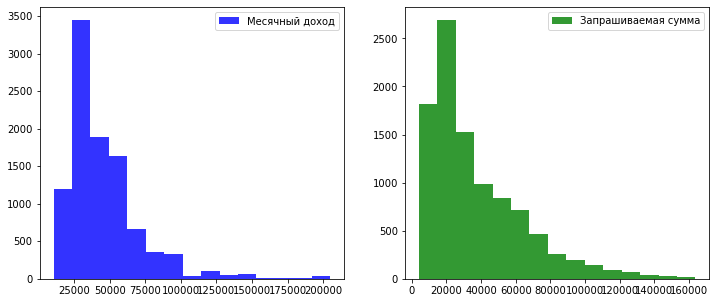

In [9]:
min_diff = np.percentile(df.monthly_income_amt, 0.5)
max_diff = np.percentile(df.monthly_income_amt, 99.5)
monthly_sample = df.monthly_income_amt.values
monthly_sample = monthly_sample[(min_diff < monthly_sample) & (monthly_sample < max_diff)]

min_diff = np.percentile(df[df.required_amt.notnull()].required_amt, 0.5)
max_diff = np.percentile(df[df.required_amt.notnull()].required_amt, 99.5)
required_sample = df[df.required_amt.notnull()].required_amt
required_sample = required_sample[(min_diff < required_sample) & (required_sample < max_diff)]                      

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(monthly_sample,
           bins = 15,
           color = 'b',
           alpha = 0.8,
           label = 'Месячный доход')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(required_sample,
           bins = 15,
           color = 'g',
           alpha = 0.8,
           label = 'Запрашиваемая сумма') 
pylab.legend()
pylab.show()

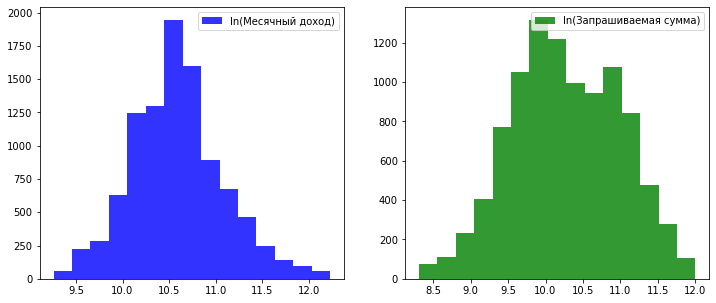

In [10]:
monthly_sample = np.log(monthly_sample)
required_sample = np.log(required_sample)

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(monthly_sample,
           bins = 15,
           color = 'b',
           alpha = 0.8,
           label = 'ln(Месячный доход)')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(required_sample,
           bins = 15,
           color = 'g',
           alpha = 0.8,
           label = 'ln(Запрашиваемая сумма)') 
pylab.legend()
pylab.show()

In [11]:
diff_pred_int = _tconfint_generic(monthly_sample.mean(),
                                  monthly_sample.std(ddof=1),                                  
                                  len(df) - 1,
                                  0.05,
                                  'two-sided')
diff_pred_int = np.exp(diff_pred_int)

print(f'amount difference 95% predictive interval for monthly_income_amt: [{diff_pred_int[0]:,.2f} - {diff_pred_int[1]:,.2f}]')

diff_pred_int = _tconfint_generic(required_sample.mean(),
                                  required_sample.std(ddof=1),                                  
                                  len(df[df.required_amt.notnull()]) - 1,
                                  0.05,
                                  'two-sided')
diff_pred_int = np.exp(diff_pred_int)

print(f'amount difference 95% predictive interval for required_amt: [{diff_pred_int[0]:,.2f} - {diff_pred_int[1]:,.2f}]')



amount difference 95% predictive interval for monthly_income_amt: [14,873.91 - 106,073.71]
amount difference 95% predictive interval for required_amt: [7,012.38 - 119,091.98]


№ 2

Определить для каждого признака, разделяет ли он риски. Т.е. надо строить доверительные интервалы для approved_flg по каждому признаку. Подсказка: для бинарных признаков можно строить интервалы на разность долей, для вещественных признаков - используйте разбивки на бакеты (группы равного размера) и сравнивайте полученные интервалы между этими группами. Попробуйте визуализировать результаты (для вещественных признаков).

Задача - понять, равномерно ли на всем объеме выборки распределено одобрение, сравнить одобрение при разных условиях.

1) высшее образование (бинарный признак)

In [12]:
approved_sample = df[df.approved_flg == 1]
disapproved_sample = df[df.approved_flg == 1]

Сравним доли клиентов с высшим образованием среди одобренных и неодобренных заявок

In [13]:
good_client_education_conf_int = proportion_confint(df[df.approved_flg == 1].has_high_education_flg.sum(),
                                                    len(df[df.approved_flg == 1].has_high_education_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
bad_client_education_conf_int = proportion_confint(df[df.approved_flg == 0].has_high_education_flg.sum(),
                                                    len(df[df.approved_flg == 0].has_high_education_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'approved client has_high_education 99% confidence interval: [{good_client_education_conf_int[0]:.3f} - {good_client_education_conf_int[1]:.3f}]')
print(f'disapproved client has_high_education 99% confidence interval: [{bad_client_education_conf_int[0]:.3f} - {bad_client_education_conf_int[1]:.3f}]')

approved client has_high_education 99% confidence interval: [0.417 - 0.467]
disapproved client has_high_education 99% confidence interval: [0.307 - 0.335]


Интервалы не пересекаются. Среди одобренных заявок доля клиентов с высшим образованием выше.
Теперь сравним доли одобренных заявок среди клиентов с высшим образованием и без. Для этого построим доверительный интервал для доли одобренных заявок.

In [14]:
approved_client_conf_int = proportion_confint(df[df.has_high_education_flg == 1].approved_flg.sum(),
                                                    len(df[df.has_high_education_flg == 1].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'approved applications for clients with high education  99% confidence interval: [{approved_client_conf_int[0]:.3f} - {approved_client_conf_int[1]:.3f}]')

approved_client_conf_int = proportion_confint(df[df.has_high_education_flg == 0].approved_flg.sum(),
                                                    len(df[df.has_high_education_flg == 0].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
print(f'approved applications for clients without high education 99% confidence interval: [{approved_client_conf_int[0]:.3f} - {approved_client_conf_int[1]:.3f}]')

approved applications for clients with high education  99% confidence interval: [0.307 - 0.348]
approved applications for clients without high education 99% confidence interval: [0.212 - 0.239]


Интервалы не пересекаются. Доля одобренных заявок для людей с высшим образованием выше.

In [15]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в независимых выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    sigma = np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    left_boundary = (p1 - p2) - z * sigma
    right_boundary = (p1 - p2) + z * sigma
    return (left_boundary, right_boundary)

2) installment_flg - флаг промо продукта (кредит или рассрочка)

Сравним доли одобренных заявок среди рассрочек и кредитов.

In [16]:
approved_client_conf_int = proportion_confint(df[df.installment_flg == 1].approved_flg.sum(),
                                                    len(df[df.installment_flg == 1].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
print(f'approved applications for installment 99% confidence interval: [{approved_client_conf_int[0]:.3f} - {approved_client_conf_int[1]:.3f}]')

approved_client_conf_int = proportion_confint(df[df.installment_flg == 0].approved_flg.sum(),
                                                    len(df[df.installment_flg == 0].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'approved applications for credit 99% confidence interval: [{approved_client_conf_int[0]:.3f} - {approved_client_conf_int[1]:.3f}]')

approved applications for installment 99% confidence interval: [0.247 - 0.275]
approved applications for credit 99% confidence interval: [0.244 - 0.281]


Интервалы пересекаются. Построим доверительный интервал для разности долей для уточнения оценки.

In [17]:
proportions_confint_diff_ind(df[df.installment_flg == 1].approved_flg,
                             df[df.installment_flg == 0].approved_flg)

(-0.02488224598127247, 0.021904336839108467)

В интервале лежит нуль, причем интвервал почти не смещен относительно него. Если бы интервал не содержал нуль, например, лежал бы справа от него, то можно было бы сделать вывод о том, что доля одобренных заявок в рассрочке больше, чем доля одобренных заявок в кредитах. Нуль в интервале и отсутсвие ощутимого смещения около него не позволяют сделать такой вывод. 

3) age - возраст

Посмотрим на признак на гистрограмме, чтобы понять, как он распределен на наших данных.

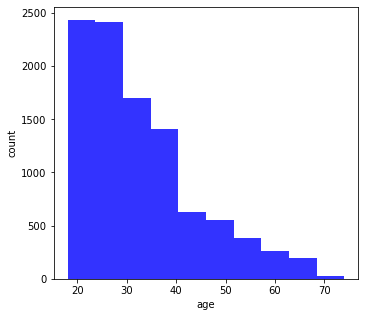

In [18]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df.age,
           # bins = 10,
           color = 'b',
           alpha = 0.8)
pylab.xlabel('age')
pylab.ylabel('count')
pylab.show()   

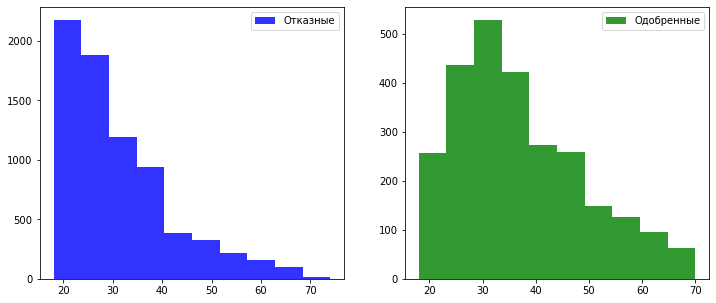

In [19]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df[df.approved_flg == 0].age,
           bins = 10,
           color = 'b',
           alpha = 0.8,
           label = 'Отказные')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(df[df.approved_flg == 1].age,
           bins = 10,
           color = 'g',
           alpha = 0.8,
           label = 'Одобренные')
pylab.legend()

pylab.show()

Данные графики не позволяют сделать нам осмысленных выводов. Мы можем заметить как сходства (уменьшение частоты с увеличением возраста), так и различия (формы графиков не совсем одного типа). Нам интересно сделать выводы о том, как меняется доля одобреннх заявок в зависимости от возраста, так как мы хотим понять, есть ли причинно-следственная или просто корреляционная связь между этими величинами.

Для этого поделим признак на бакеты и посмотрим на доли одобренных заявок в различных возрастных группах.

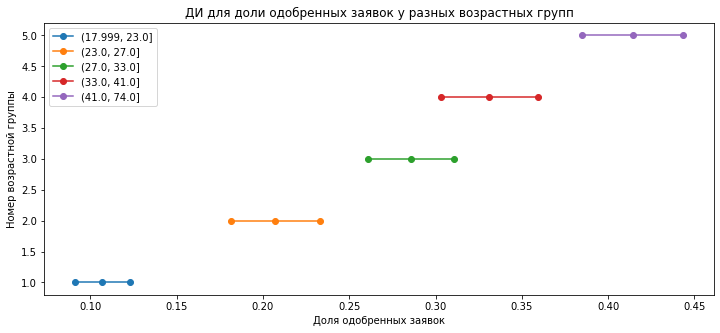

In [122]:
num = 5
age_data = df.age

mask_array = []
def CI_for_quantitative_attributes_(data, numbers):
    approved_client_conf_int_array = []
    # делаем buckets    
    buckets = pd.qcut(data.values, numbers).categories
    
    for i in range(numbers):
        a = buckets[i].left
        b = buckets[i].right
        mask = ((data <= b) & (data > a))
        mask_array.append(mask)
        new_el = proportion_confint(df[mask].approved_flg.sum(),
                                                    len(df[mask].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
        approved_client_conf_int_array.append(new_el)
        
    for i in range(numbers): 
        pylab.plot([approved_client_conf_int_array[i][0],approved_client_conf_int_array[i][1]],[i + 1,i + 1], marker='o',label=str(buckets[i]))
        center = (approved_client_conf_int_array[i][1] - approved_client_conf_int_array[i][0]) * 0.5 + approved_client_conf_int_array[i][0]
        pylab.scatter(center, i + 1)
    
    pylab.legend()
    return buckets

buckets = CI_for_quantitative_attributes_(age_data, num)
pylab.title('ДИ для доли одобренных заявок у разных возрастных групп')
pylab.xlabel('Доля одобренных заявок')
pylab.ylabel('Номер возрастной группы')
pylab.show()

Некоторые интервалы пересекаются.

Этот факт для нас не очень информативен, потому что нельзя однозначно сказать, что какой-то диапазон больше другого и предположить взаимосвязь между данными возрастными группами и долей одобренных заявок. 
Число интервалов не задается математической формулой, поэтому его стоит искать более эмпирическим или экспериментальным путем. 
В контексте возраста мы привыкли делить совершеннолетних людей на три основные группы - молодые, взрослые, старые. Однако, если мы выберем n = 3, то можем не получить такие категории (с возрастом заявок меньше, ширина интервала для третьей группы будет шире). Проверим этот момент.

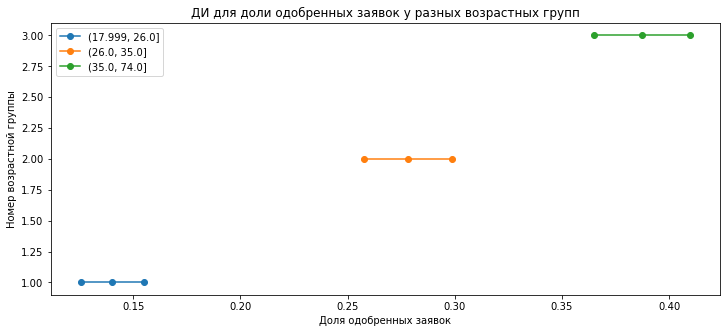

In [22]:
num = 3
age_data = df.age

mask_array = []

buckets = CI_for_quantitative_attributes_(age_data, num)
pylab.title('ДИ для доли одобренных заявок у разных возрастных групп')
pylab.xlabel('Доля одобренных заявок')
pylab.ylabel('Номер возрастной группы')
pylab.show()

Интервал от 35 лет и старше нельзя назвать категорией "старых" людей, но мы все равно получили интересную картину, потому что интервалы не пересекаются. 
Рассмотрим разные значения n и изобразим интервалы.

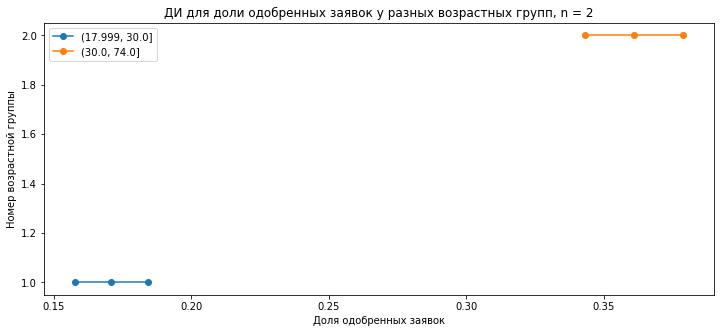

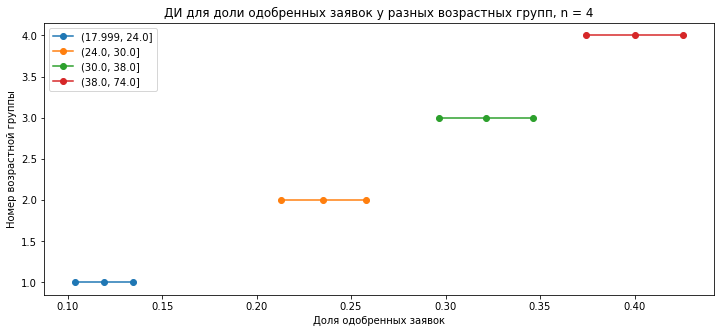

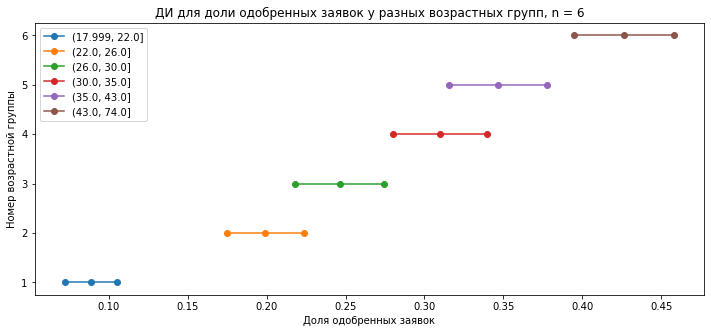

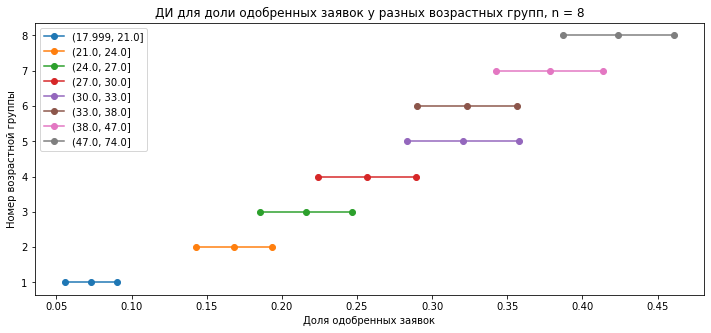

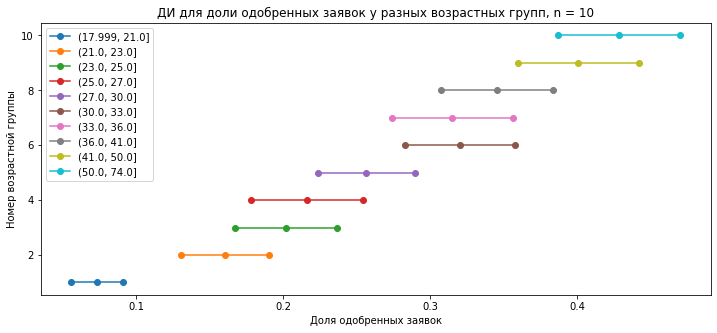

In [85]:
n = 0
age_data = df.age

for i in range(5):
    n = n + 2
    mask_array = []
    
    buckets = CI_for_quantitative_attributes_(age_data, n)
    pylab.title('ДИ для доли одобренных заявок у разных возрастных групп, n = ' + str(n))
    pylab.xlabel('Доля одобренных заявок')
    pylab.ylabel('Номер возрастной группы')
    pylab.show()

Заметна некоторая тенденция. Интервалы начинают пересекаться с увеличением числа бакетов. Видим, что слишком большие n размывают разницу между группами и что интервалы смещаются в правую сторону вместе с возрастом. Для демонстрации непересекающихся интервалов непринципиально, какое из n < 5 рассматривать. 

Можно сделать вывод, что есть взаимосвязь между возрастом и долей одобренных заявок, но природу связи таким образом объяснить нельзя (возможны скрытые переменные,взаимодействие в связке с другими признаками и тому подобное).

In [ ]:
'''num = 5
age_data = df.age

mask_array = []

buckets = CI_for_quantitative_attributes_(age_data, num)
print('Сравнение интервалов между собой:\n')

str_3 = '\tCI:'
for i in range(num):
    for j in range(num-i):
        if i == j+i:
            continue
        str_1 = 'AGE: ' + str(buckets[i].left) + '-' + str(buckets[i].right)
        str_2 = 'and ' + str(buckets[i+j].left) + '-' + str(buckets[i+j].right)
        val = proportions_confint_diff_ind(df[mask_array[i]].approved_flg,
                             df[mask_array[j]].approved_flg)
        print(str_1,str_2, str_3, str(val))'''

In [ ]:
'''num  = 5
age_data = df.age

mask_array = []
def CI_for_quantitative_attributes(data, numbers):
    approved_client_conf_int_array = []
    # делает bins
    bins = pd.cut(data.values, numbers).categories 

    for i in range(numbers):
        a = bins[i].left
        b = bins[i].right
        mask = ((data <= b) & (data > a))
        mask_array.append(mask)
        new_el = proportion_confint(df[mask].approved_flg.sum(),
                                                    len(df[mask].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
        approved_client_conf_int_array.append(new_el)

    
    for i in range(numbers): 
        pylab.plot([approved_client_conf_int_array[i][0],approved_client_conf_int_array[i][1]],[i + 1,i + 1], marker='o',label=str(bins[i]))
        center = (approved_client_conf_int_array[i][1] - approved_client_conf_int_array[i][0]) * 0.5 + approved_client_conf_int_array[i][0]
        pylab.scatter(center, i + 1)
    
    pylab.legend()
    return bins

bins = CI_for_quantitative_attributes(age_data, num)
pylab.title('ДИ для доли одобренных заявок у разных возрастных групп')
pylab.xlabel('Доля одобренных заявок')
pylab.ylabel('Номер возрастной группы')
pylab.show()'''

In [ ]:
''''print('Сравнение интервалов между собой:\n')

str_3 = '\tCI:'
for i in range(numbers):
    for j in range(numbers-i):
        if i == j+i:
            continue
        str_1 = 'AGE: ' + str(bins[i].left) + '-' + str(bins[i].right)
        str_2 = 'and ' + str(bins[i+j].left) + '-' + str(bins[i+j].right)
        val = proportions_confint_diff_ind(df[mask_array[i]].approved_flg,
                             df[mask_array[j]].approved_flg)
        print(str_1,str_2, str_3, str(val))'''

4) Ежемесячный доход

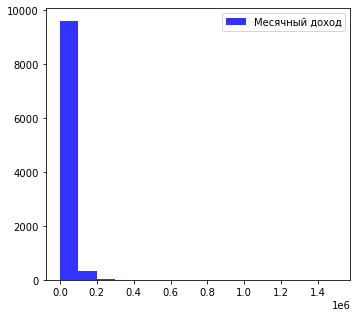

In [164]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
monthly_sample = df.monthly_income_amt.values
pylab.hist(monthly_sample,
           bins = 15,
           color = 'b',
           alpha = 0.8,
           label = 'Месячный доход')
pylab.legend()
pylab.show()

На графике не видно разницы частот во встречающемся диапазоне до определенного уровня дохода, там частота резко падает (довольно традиционное смещение доходов в том плане, что крупные сумму получают меньшее количество людей). Попробуем избавиться от хвостов.

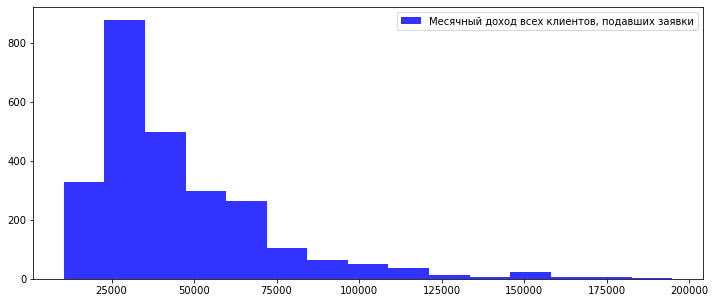

In [177]:
min_diff = np.percentile(df.monthly_income_amt, 0.5)
max_diff = np.percentile(df.monthly_income_amt, 99.5)
monthly_sample = monthly_sample[(min_diff < monthly_sample) & (monthly_sample < max_diff)]
pylab.figure(figsize(12, 5))
pylab.hist(monthly_sample,
           bins = 15,
           color = 'b',
           alpha = 0.8,
           label = 'Месячный доход всех клиентов, подавших заявки')
pylab.legend()
pylab.show()

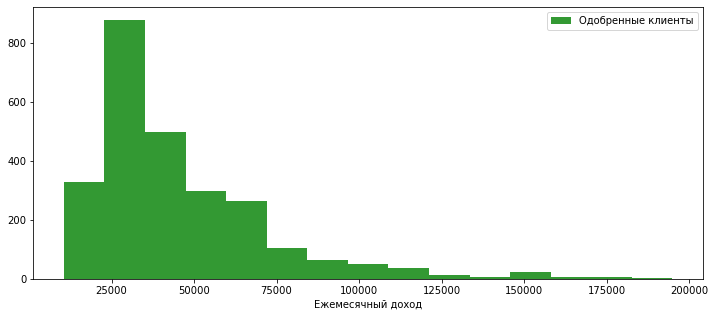

In [178]:
pylab.figure(figsize(12, 5))
monthly_sample = df[df.approved_flg == 1].monthly_income_amt.values # ежемесячный доход одобренных клиентов
min_diff = np.percentile(df[df.approved_flg == 1].monthly_income_amt, 0.5)
max_diff = np.percentile(df[df.approved_flg == 1].monthly_income_amt, 99.5)
monthly_sample = monthly_sample[(min_diff < monthly_sample) & (monthly_sample < max_diff)]

pylab.hist(monthly_sample,
           bins = 15,
           color = 'g',
           alpha = 0.8,
           label = 'Одобренные клиенты')
pylab.legend()
pylab.xlabel('Ежемесячный доход')

pylab.show()

Видим, что одобренных заявок больше среди меньших доходов. Будем проверять, связано ли это просто с количеством заявок или доля одобренных заявок связана с доходами по-другому. Будем аналогично предыдущему пункту создавать бакеты и искать разницу.
Рассуждая о доходах, принято говорить о среднем заработке, производить сравнения с этой величиной и так далее. Исходя из этого и из того, что большинство доходов сосредоточено в левой стороне графиков, кажется нецелесообразным рассматривать разбиение на большое количество бакетов. Проверим это.

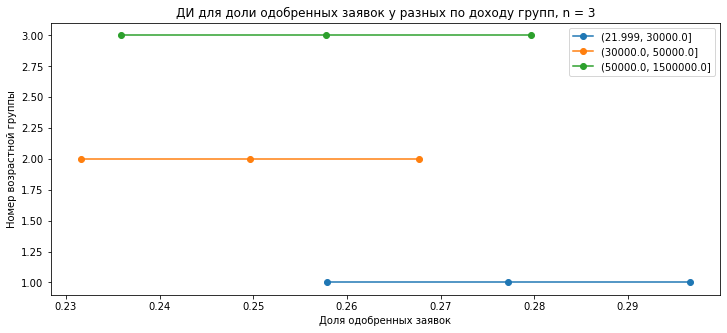

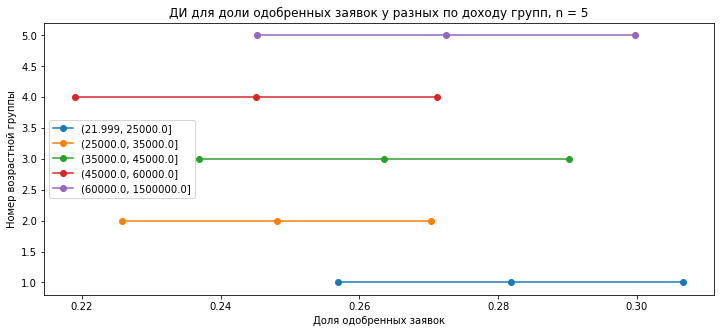

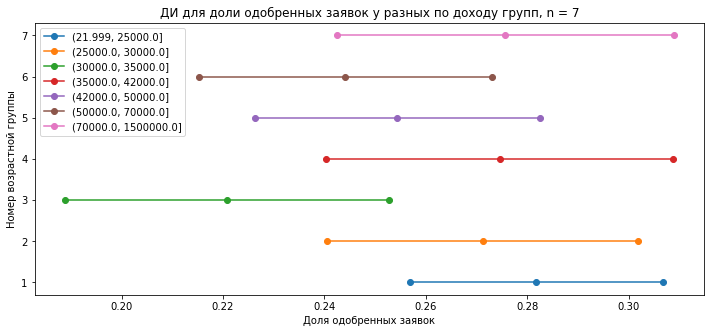

In [181]:
n = 1
monthly_data = df.monthly_income_amt

for i in range(3):
    n = n + 2
    mask_array = []
    
    buckets = CI_for_quantitative_attributes_(monthly_data, n)
    pylab.title('ДИ для доли одобренных заявок у разных по доходу групп, n = ' + str(n))
    pylab.xlabel('Доля одобренных заявок')
    pylab.ylabel('Номер возрастной группы')
    pylab.show()

С увеличением числа бакетов ситуация не становится более информативной. Попробуем сделать выводы хотя бы относительно случая n = 3.

Сравнение интервалов между собой:

INCOME: 21.999-30000.0 and 30000.0-50000.0 	CI: (0.001148875069148625, 0.05409741823003744)
INCOME: 21.999-30000.0 and 50000.0-1500000.0 	CI: (-0.009560444970070029, 0.04888230818204542)
INCOME: 30000.0-50000.0 and 50000.0-1500000.0 	CI: (-0.02552109809502334, 0.02552109809502334)


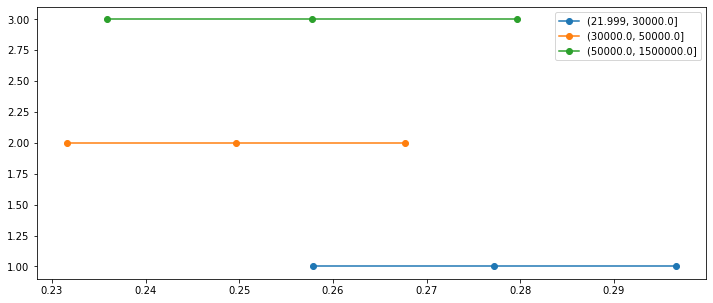

In [182]:
print('Сравнение интервалов между собой:\n')

monthly_data = df.monthly_income_amt
mask_array = []
num = 3

buckets = CI_for_quantitative_attributes_(monthly_data, num)

str_3 = '\tCI:'
for i in range(num):
    for j in range(num-i):
        if i == j+i:
            continue
        str_1 = 'INCOME: ' + str(buckets[i].left) + '-' + str(buckets[i].right)
        str_2 = 'and ' + str(buckets[i+j].left) + '-' + str(buckets[i+j].right)
        val = proportions_confint_diff_ind(df[mask_array[i]].approved_flg,
                             df[mask_array[j]].approved_flg)
        print(str_1,str_2, str_3, str(val))


В первом случае все значения находятся справа от нуля. Отсюда вывод о том, что людям с доходом до 30.000 рублей чаще дают согласие, чем людям с доходом от 30 до 50к. Два других интервала содержат нуль и нуль и перекос относительно нуля, что не позволяет произвести ту оценку, которую хотелось бы. С увеличением числа n все больше интервалов пересакаются, необходимо производить все больше сравнений. Это затрудняет, во-первых, сам процесс. Во-вторых, в статистике есть проблемы, связанные с множественным сравнением.

In [468]:
''''numbers = 2
data = df.monthly_income_amt
bins = pd.cut(data.values, numbers).categories 

approved_client_conf_int_array = []
mask_array = []

for i in range(numbers):
        a = bins[i].left
        b = bins[i].right
        mask = ((data <= b) & (data > a))
        mask_array.append(mask)
        new_el = proportion_confint(df[mask].approved_flg.sum(),
                                                    len(df[mask].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
        approved_client_conf_int_array.append(new_el)
'''

In [ ]:
'''for i in range(numbers): 
        pylab.plot([approved_client_conf_int_array[i][0],approved_client_conf_int_array[i][1]],[i + 1,i + 1], marker='o',label=str(bins[i]))
        center = (approved_client_conf_int_array[i][1] - approved_client_conf_int_array[i][0]) * 0.5 + approved_client_conf_int_array[i][0]
        pylab.scatter(center, i + 1)
    
pylab.legend()'''

5) Запрашиваемая сумма

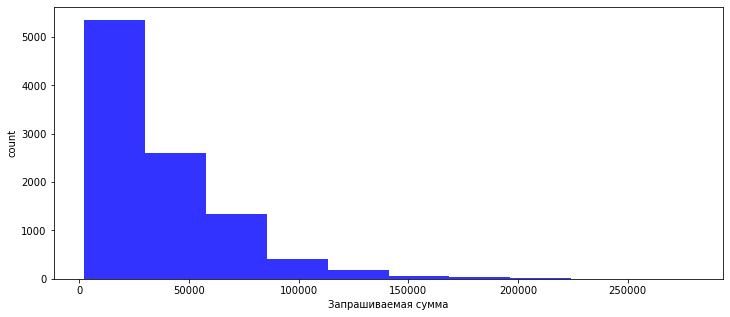

In [156]:
pylab.figure(figsize(12, 5))
pylab.hist(df.required_amt,
          # bins = 2,
           color = 'b',
           alpha = 0.8)
pylab.xlabel('Запрашиваемая сумма')
pylab.ylabel('count')
pylab.show()  

С запрашиваемой суммой будем действовать по той же схеме. Из визуализации видим, что есть перекос в сторону меньших сумм. 

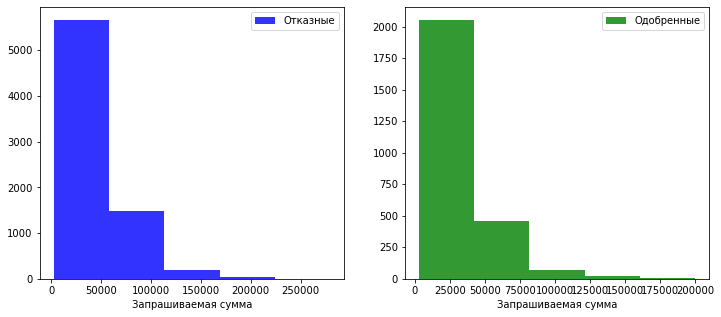

In [61]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df[df.approved_flg == 0].required_amt,
           bins = 5,
           color = 'b',
           alpha = 0.8,
           label = 'Отказные')
pylab.xlabel('Запрашиваемая сумма')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(df[df.approved_flg == 1].required_amt,
           bins = 5,
           color = 'g',
           alpha = 0.8,
           label = 'Одобренные')
pylab.legend()
pylab.xlabel('Запрашиваемая сумма')

pylab.show()

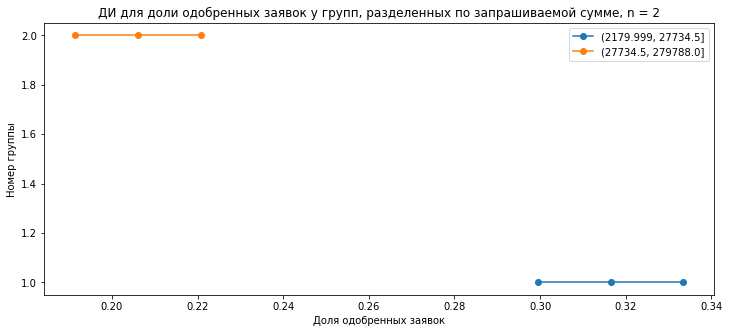

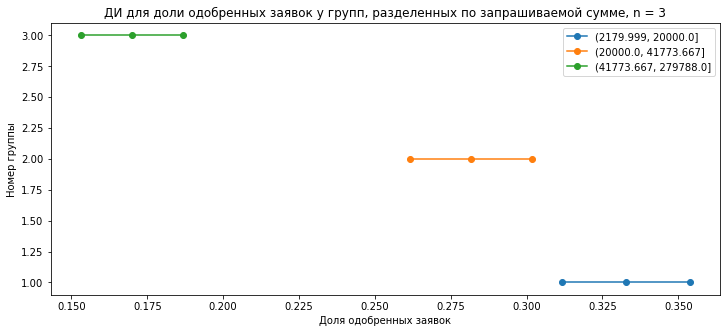

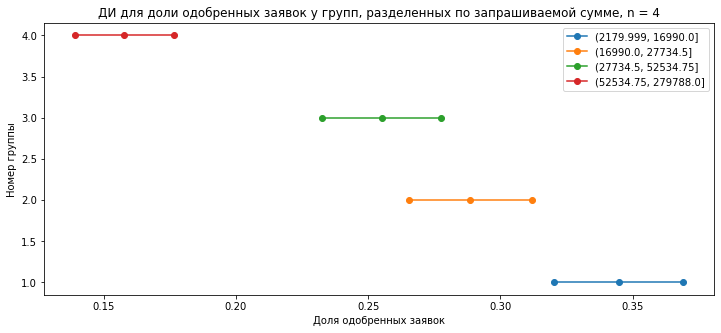

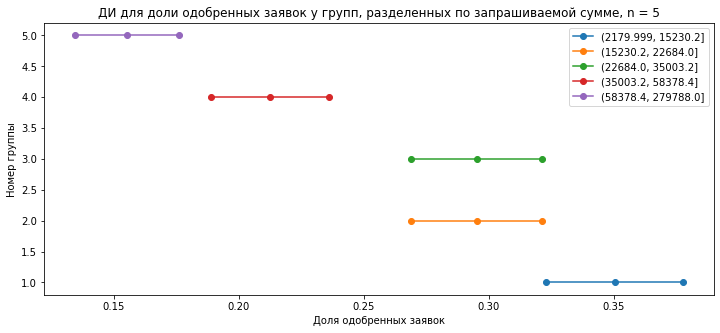

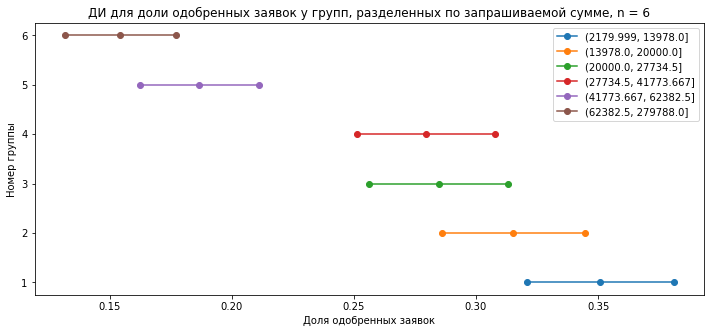

In [185]:
n = 1
data = df.required_amt

for i in range(5):
    n = n + 1
    mask_array = []
    
    buckets = CI_for_quantitative_attributes_(data, n)
    pylab.title('ДИ для доли одобренных заявок у групп, разделенных по запрашиваемой сумме, n = ' + str(n))
    pylab.xlabel('Доля одобренных заявок')
    pylab.ylabel('Номер группы')
    pylab.show()


В какой-то момент интервалы начинают пересекаться, но видно, что отрезки смещаются влево с увеличением запрашиваемой суммы. Как и с возрастом, наблюдается связь, природа которой требует более тщаельного изучения.

№3

Введите бинарный признак (какая сумма больше - запрошенная или ежемесячная зарплата) - оцените точечно и интервально шансы (odds) одобрения в зависимости от этого признака $$\text{odds: } \frac{p}{1-p}$$ Постройте также интервал для отношения шансов на этих выборках. *Подсказка:* используйте бутстреп.

In [426]:
df['income_is_higher'] = df.monthly_income_amt > df.required_amt

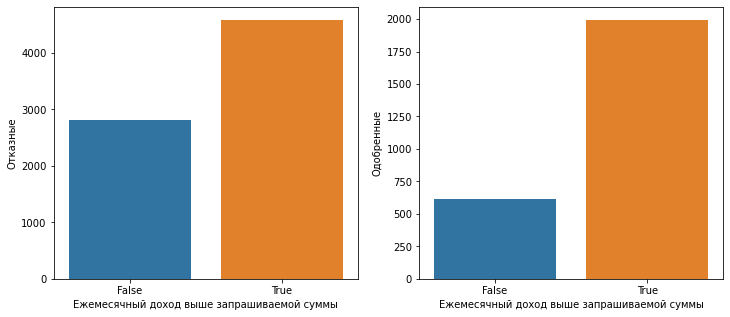

In [427]:

pylab.subplot(1,2,1)
sns.countplot(x='income_is_higher', data=df[df.approved_flg == 0])
pylab.ylabel('Отказные')
pylab.xlabel('Ежемесячный доход выше запрашиваемой суммы')


pylab.subplot(1,2,2)
sns.countplot(x='income_is_higher', data=df[df.approved_flg == 1])
pylab.ylabel('Одобренные')
pylab.xlabel('Ежемесячный доход выше запрашиваемой суммы')


pylab.show()

Точная оценка шанса на имеющихся данных:

In [428]:
mask = df.income_is_higher == True 
all_count = len(df[mask])
mask = mask & (df.approved_flg == 1)
p = len(df[mask]) / all_count # Доля одобренных заявок с таким признаком(=true)
odds = p / (1 - p)
p

0.3029796290665856

In [492]:
reverse_mask = df.income_is_higher == False
all_count = len(df[reverse_mask])
reverse_mask = reverse_mask & (df.approved_flg == 1)
p_ = len(df[reverse_mask]) / all_count # Доля одобренных заявок с ложным значением признака(=false)
odds__ = p / (1 - p)
p_

0.18059614260666276

По данной формуле в условии точечная оценка:

In [493]:
print('odds where income_is_higher == true: ', odds)
print('odds where income_is_higher == falsw: ', odds__)

odds where income_is_higher == true:  0.43467829880043624
odds where income_is_higher == falsw:  0.43467829880043624


In [458]:
def get_bootstrap_samples(data, n_samples):
    '''Генерирует заданное кол-во (n_samples) выборок, равных по размеру исходной выборке'''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    #print(indices)
    samples = data[indices]
    return samples

In [459]:
def get_stat_intervals(stat, alpha):
    '''Для заданной выборки возвращает двусторонний доверительный интервал [aplpha/2, 1 - alpha/2]'''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Оцениваем интервально шансы

In [460]:
#считаем долю одобренных из нового сэмпла
def odds_(sample):
    p = sample.sum() / len(sample)
    return p/ (1 - p)

    
np.random.seed(0)
true_income = list(map(odds_, get_bootstrap_samples(df[df.income_is_higher == True].approved_flg.values, 1000)))
false_income = list(map(odds_, get_bootstrap_samples(df[df.income_is_higher == False].approved_flg.values, 1000)))
    
print('for income is higher 99% confidence interval:',  get_stat_intervals(true_income, 0.01))
print('for incomr is not higher 99% confidence interval:',  get_stat_intervals(false_income, 0.01))

for income is higher 99% confidence interval: [0.40826074 0.46406172]
for incomr is not higher 99% confidence interval: [0.1965035  0.24663024]


In [463]:
scores = list(map(lambda x: x[0] / x[1], zip(true_income, false_income)))
print(f'Среднее отношение: {sum(scores) / len(scores) :.2f} раз')

Среднее отношение: 1.97 раз


In [465]:
print('99% confidence interval for the scores',  get_stat_intervals(scores, 0.01))

99% confidence interval for the scores [1.73925912 2.24933349]
